In [1]:
import numpy as np
from scipy.stats import truncnorm, norm, binom, rv_continuous
import matplotlib.pyplot as plt
import random
import math

# Constants & Assumptions

In [2]:
cutoff = 0.95 # The European norm for the required accuracy of the machine

In [3]:
price = 119000 # in €, price of machine

In [4]:
cost_of_failing = price / 10 # Price company has to pay of delivering a machine that doesn't satisfy European norm

In [5]:
# cost_of_failing = 0

# Classes

In [6]:
class Wafer:
    pass

In [7]:
class SolarCell:
    def __init__(self, working):
        self.working = working

In [8]:
class Machine:
    runtime = 0  #In Minutes
    costs = 0
    
    def __init__(self, p):  #Constructor
        """Make machine with probability p of turning a wafer into a working cell."""
        self.p = p
    
    def deposit(self, wafer):
        """Deposit a Wafer, returns a SolarCell"""
        self.runtime += 9    #9 minutes per deposition per wafer
        self.costs += 2 + 87/35  #It costs €2 to do a deposition. Wafers have a base cost of €87, but can be re-used 35 times
        working = random.random() < self.p 
        
        return SolarCell(working)
    
    def diagnosis(self, cell):
        """Diagnose a SolarCell, returns whether the cell works"""
        self.runtime += 2 if cell.working else 3  # Diagnosis costs 2 minutes if the created cell works, 3 minutes otherwise
        return cell.working
    
    def test_basic(self, n):
        """Test the machine n times and return the ratio of working cells"""
        wafers = n * [Wafer()] # Create list of n Wafer() objects
        cells = list(map(self.deposit, wafers)) # Deposit all wafers
        working_cells = list(filter(self.diagnosis, cells)) # Make list of working cells
        return len(working_cells)/len(cells) # Determine ratio of the amount of working cells and total cells 
    
    def get_stats(self):
        """Pretty print the status of machine."""
        days = self.runtime // (24 * 60)
        hours = (self.runtime % (24 * 60)) // 60
        minutes = (self.runtime % (24 * 60)) % 60
        rcosts = round(self.costs, 2)
        
        print("Actual accuracy of machine:", self.p)
        print("It takes", days, "day(s),", hours, "hour(s) and", minutes, "minute(s) to test.")
        print("The costs associated with this test method is €" + str(rcosts))
        
    def reset(self):
        """Reset the machine."""
        self.runtime = 0
        self.costs = 0
        
    def plot_pmf(self, n):
        """Plot the probability of each estimation of p resulting from n tests."""
        fig, ax = plt.subplots(1, 1)
        x = np.arange(binom.ppf(0.001, n, self.p), n+1)
        ax.plot(x/n, binom.pmf(x, n, self.p), 'bo', ms=8, label='binom pmf')
        ax.vlines(x/n, 0, binom.pmf(x, n, self.p), colors='b', lw=5, alpha=0.5)
        ax.axvline(x = self.p, color='g')
        ax.set_xlabel("estimated p")
        ax.set_ylabel("probability")
        plt.show()
        
    def plot_cdf(self, n):
        """Plot cdf of estimation of p resulting from n tests."""
        fig, ax = plt.subplots(1, 1)
        x = np.arange(binom.ppf(0.001, n, self.p), n+1)
        ax.plot(x/n, binom.cdf(x, n, self.p), 'bo', ms=8, label='binom pmf')
        ax.vlines(x/n, 0, binom.cdf(x, n, self.p), colors='b', lw=5, alpha=0.5)
        ax.axvline(x = self.p, color='g')
        ax.set_xlabel("estimated p")
        ax.set_ylabel("cumulative density function")
        plt.show()

    # Testing with variable number of tests
    def test_advanced_95(self, min_tests, max_tests):
        """Test the machine until it is 95% certain that the machine works or we reached the maximum number of tests.
        Maximum number of tests is given by max_tests.
        """
        successes = 0
        p_ = 1
        
        if max_tests < min_tests:
            min_tests = max_tests + 1

        for n in range(1, min_tests):
            if self.diagnosis(self.deposit(Wafer())):
                successes += 1
            p_ = successes / n
        
        for n in range(min_tests + 1, max_tests + 1):
            if self.diagnosis(self.deposit(Wafer())):
                successes += 1
            p_ = successes / n
            
            (left, right) = Machine.wilson_score_interval_95(p_, n)
            
            if (left > cutoff and right > cutoff):
                return (p_, n)
            
            if (left < cutoff and right < cutoff):
                return (p_, n)
                   
        return (p_, n)
    
    def calculate_interval(certainty, p_, n):
        """Incorrect implementation, use wilson_score_interval_95 instead"""
        error = (1 - certainty) / 2
        
        # Bounds expressed in successes
        leftS = binom.ppf(error, n, p_)
        rightS = binom.ppf(1 - error, n, p_)
        
        # Express in p_
        return (leftS / n, rightS / n)

    
    def wilson_score_interval_95(p_, n):
        """Returns (the Wilson approximation of) the interval such that it is 95% certain that after n tests
        the actual probability of the machine lies in this interval"""
        # From https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
        z = 1.96 # for 95% confidence
        
        base = (p_ + z**2/(2*n))/(1+z**2/n)
        spread = z/(1+z**2/n) * math.sqrt((p_*(1-p_))/n + z**2/(4*n**2))
        
        left = base - spread
        right = base + spread
        
        return (left, right)
        
    def procedure_basic(self, n):
        """This basic procedure uses the test_basic to approximate the accuracy of the machine.
        The basic test takes n wafers and returns the ratio (=p_) of working wafers"""
        return self.test_basic(n) >= cutoff
    
    def procedure_advanced_95(self, min_tests, max_tests):
        """This procedure uses test_advanced to approximate the accuracy of the machine."""
        (p_, n) = self.test_advanced_95(min_tests, max_tests)
        return p_ >= cutoff
    
    def procedure_advanced_95_true(self, min_tests, max_tests):
        """This procedure uses test_advanced to approximate the accuracy of the machine."""
        (p_, n) = self.test_advanced_95(min_tests, max_tests)
        if n == max_tests:
            return True
        else: return p_ >= cutoff
        
    def procedure_advanced_95_false(self, min_tests, max_tests):
        """This procedure uses test_advanced to approximate the accuracy of the machine."""
        (p_, n) = self.test_advanced_95(min_tests, max_tests)
        if n == max_tests:
            return False
        else: return p_ >= cutoff
    
    def procedure_trivial(self):
        # This testing procedure basically doesn't test, but accepts all machines
        # Used for cost computation purposes
        return True


In [9]:
class double_trunc_norm_gen(rv_continuous):
    # Doesn't work for generating rvs, but still useful for plotting
    "Double truncated normal"
    def _pdf(self, x, mu1, sigma1, mu2, sigma2, step):
        return step * truncnorm.pdf(x, -mu1 / sigma1, (1 - mu1) / sigma1, loc=mu1, scale=sigma1) \
             + (1-step) * truncnorm.pdf(x, -mu2 / sigma2, (1 - mu2) / sigma2, loc=mu2, scale=sigma2)

In [10]:
double_trunc_norm = double_trunc_norm_gen(name="double truncated normal")

## Factory

In [11]:
class Factory:
    def __init__(self, mu, sigma):
        """Factory that makes a machine with accuracies normally distributed."""
        self.mu = mu
        self.sigma = sigma
        
    def makeMachines(self, n):
        """Make machine"""
        ps = truncnorm(-self.mu / self.sigma, (1 - self.mu) / self.sigma, loc=self.mu, scale=self.sigma).rvs(n)
        return list(map(Machine, ps))
    
    def makeMachine(self):
        return self.makeMachines(1)[0]
    
    def test_testing_procedure(self, procedure, n, **kwargs): #onhandige naam maarja...
        """Test a procedure on machines normally distributed with mu sigma (truncated) n times.
        Procedure is a function that takes a machine and returns whether the machine works correctly."""
        successes = 0
        costs = 0
        time = 0
        
        machines = kwargs.get('batch', self.makeMachines(n))
#         machines = self.makeMachines(n)

        for m in machines:
            # if procedure gives correct result
            if procedure(m) == (m.p >= cutoff):
                successes += 1

            costs += m.costs
            time += m.runtime
            
            m.reset()

        costs /= n
        time /= n
        accuracy = successes / n
        
        total_costs = costs + (1 - accuracy) * cost_of_failing
        
        return (total_costs, costs, time, accuracy)
    
    def print_testing_procedure(self, procedure, n):
        (total_costs, costs, time, accuracy) = self.test_testing_procedure(procedure, n)
        
        print(f"Testing procedure was accurate {accuracy * 100}% of the time.")

        days = time // (24 * 60)
        hours = (time % (24 * 60)) // 60
        minutes = (time % (24 * 60)) % 60
        rcosts = round(costs, 2)
        
        r_total_costs = round(total_costs, 2)

        print("Test procedure took on average ", days, "day(s),", hours, "hour(s) and", minutes, "minute(s).")
        print("The costs associated with this test procedure is on average €" + str(rcosts))
        print(f"Total costs is on average € {r_total_costs}")
    
    def compare_testing_procedures(self, procedure1, procedure2, n, **kwargs):
        """Get two procedures and return the name, min_costs and min_time of the cheapest one"""
        batch = kwargs.get('batch', None)
        if batch:
            (total_costs1, costs1, time1, accuracy1) = self.test_testing_procedure(procedure1, n, batch=batch)
            (total_costs2, costs2, time2, accuracy2) = self.test_testing_procedure(procedure2, n, batch=batch)
        else:
            (total_costs1, costs1, time1, accuracy1) = self.test_testing_procedure(procedure1, n)
            (total_costs2, costs2, time2, accuracy2) = self.test_testing_procedure(procedure2, n)

        if total_costs1 < total_costs2:
            min_total_costs = total_costs1
            costs = costs1
            time = time1
            name = procedure1.__name__
            accuracy = accuracy1
        else:
            min_total_costs = total_costs2
            costs = costs2
            time = time2
            name = procedure2.__name__
            accuracy = accuracy2
        return (name, min_total_costs, costs, time, accuracy)
    
    def compare_list_testing_procedures(self, procedures, n, **kwargs):
        batch = kwargs.get('batch', None)
        name = ""
        min_total_costs = 999999999999999
        for i in range(len(procedures)-1):
            print(procedures[i].__name__)
            print(procedures[i+1].__name__)
            if batch:
                (name_, min_total_costs_, costs_, time_, accuracy_) = self.compare_testing_procedures(procedures[i], procedures[i+1], n, batch=batch)
            else:
                (name_, min_total_costs_, costs_, time_, accuracy_) = self.compare_testing_procedures(procedures[i], procedures[i+1], n)
            print(name_, min_total_costs_, costs_, time_, accuracy_)
            print()
            if min_total_costs_ < min_total_costs:
                min_total_costs = min_total_costs_
                time = time_
                costs = costs_
                accuracy = accuracy_
                name = name_
        return (name, min_total_costs, costs, time, accuracy)

In [12]:
class AltFactory(Factory):
    def __init__(self, mu1, sigma1, mu2, sigma2, step):
        """Factory that makes a machine with accuracies taken from two normal distributions, truncated between 0 and 1.
        With probability step from a truncated normal distribution around mu1 with deviation sigma1.
        With probability 1-step from a truncated normal distribution around mu2 with deviation sigma2.
        """
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.mu2 = mu2
        self.sigma2 = sigma2
        self.step = step
        
    def makeMachines(self, n):
        """Make machine"""
        if random.random() < self.step:
            mu = self.mu1
            sigma = self.sigma1
        else:
            mu = self.mu2
            sigma = self.sigma2
        ps = truncnorm(-mu / sigma, (1 - mu) / sigma, loc=mu, scale=sigma).rvs(n)
        return map(Machine, ps)

# Playground

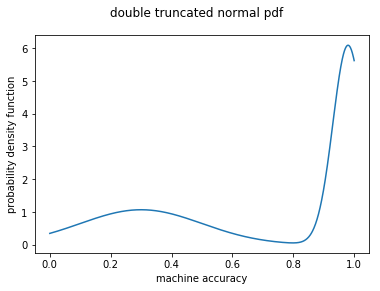

In [13]:
mu1 = 0.98
sigma1 = 0.05
mu2 = 0.3
sigma2 = 0.2

fig, ax = plt.subplots(1, 1)
x = np.arange(0, 1.001, 0.001)
ax.plot(x, double_trunc_norm.pdf(x, mu1, sigma1, mu2, sigma2, 0.5))
ax.set_xlabel("machine accuracy")
ax.set_ylabel("probability density function")
fig.suptitle('double truncated normal pdf')
plt.show()

# Proper Testing

In [14]:
def basic(n):
    f = lambda m : m.procedure_basic(n)
    f.__name__ = f"Basic({n})"
    return f

In [15]:
def advanced(min_n, max_n):
    f = lambda m : m.procedure_advanced_95(min_n, max_n)
    f.__name__ = f"Advanced({min_n}, {max_n})"
    return f

In [16]:
def advanced_true(min_n, max_n):
    f = lambda m : m.procedure_advanced_95_true(min_n, max_n)
    f.__name__ = f"Advanced True ({min_n}, {max_n})"
    return f

In [17]:
def advanced_false(min_n, max_n):
    f = lambda m : m.procedure_advanced_95_false(min_n, max_n)
    f.__name__ = f"Advanced False ({min_n}, {max_n})"
    return f

In [18]:
f = Factory(0.98, 0.05)
alt_f = AltFactory(0.98, 0.05, 0.3, 0.2, 0.98)

In [19]:
def test_basic_vs_advanced(factory):
    ns = range(100, 400, 10)
    procedures = list(map(basic, ns)) + list(map(lambda max_n: advanced(50, max_n), ns))
    (name, min_cost, min_time) = factory.compare_list_testing_procedures(procedures, 2000)

In [20]:
batch = f.makeMachines(10000)

In [21]:
def test_advanced_tests(factory, advanced_procedure):
    min_ns = range(0, 100, 50)
    max_ns = range(100, 400, 50)
    procedures = []
    for min_n in min_ns:
        for max_n in max_ns:
            procedures.append(advanced_procedure(min_n, max_n))
    (name, min_total_costs, costs, time, accuracy) = factory.compare_list_testing_procedures(procedures, 10000, batch=batch)
    print(f"Test with minimal cost is {name}, with total_costs €{min_total_costs}, costs €{costs}, time {time} and accuracy {accuracy}")

In [22]:
test_advanced_tests(alt_f, advanced)

Advanced(0, 100)
Advanced(0, 150)
Advanced(0, 150) 2301.0719942857477 426.82199428574813 1050.6044 0.8425

Advanced(0, 150)
Advanced(0, 200)
Advanced(0, 200) 2328.57897142855 510.25897142854956 1256.0318 0.8472

Advanced(0, 200)
Advanced(0, 250)
Advanced(0, 250) 2292.9701028571076 582.940102857107 1434.9903 0.8563

Advanced(0, 250)
Advanced(0, 300)
Advanced(0, 250) 2256.339497142819 585.5794971428193 1441.4997 0.8596

Advanced(0, 300)
Advanced(0, 350)
Advanced(0, 300) 2271.510908571422 650.7309085714226 1601.9886 0.8638

Advanced(0, 350)
Advanced(50, 100)
Advanced(0, 350) 2328.8052914285518 702.075291428551 1728.4068 0.8633

Advanced(50, 100)
Advanced(50, 150)
Advanced(50, 150) 2189.6188057143468 533.1388057143471 1312.3048 0.8608

Advanced(50, 150)
Advanced(50, 200)
Advanced(50, 200) 2141.2058628571053 645.3758628571051 1588.5554 0.8743

Advanced(50, 200)
Advanced(50, 250)
Advanced(50, 250) 2130.9829971427885 743.442997142788 1829.9558 0.8834

Advanced(50, 250)
Advanced(50, 300)
Advan

In [23]:
test_advanced_tests(alt_f, advanced_false)

Advanced False (0, 100)
Advanced False (0, 150)
Advanced False (0, 150) 4285.311631428605 428.5216314286041 1054.7806 0.6759

Advanced False (0, 150)
Advanced False (0, 200)
Advanced False (0, 200) 3970.720717142838 511.3907171428387 1258.7874 0.7093

Advanced False (0, 200)
Advanced False (0, 250)
Advanced False (0, 250) 3650.7899171428244 578.2099171428247 1423.3492 0.7418

Advanced False (0, 250)
Advanced False (0, 300)
Advanced False (0, 300) 3464.5161571428516 650.166157142851 1600.5279 0.7635

Advanced False (0, 300)
Advanced False (0, 350)
Advanced False (0, 350) 3284.7231742856934 707.1831742856936 1740.939 0.7834

Advanced False (0, 350)
Advanced False (50, 100)
Advanced False (0, 350) 3333.6830342856933 713.303034285694 1756.0078 0.7798

Advanced False (50, 100)
Advanced False (50, 150)
Advanced False (50, 150) 5414.125020000062 533.9350200000615 1314.3199 0.5899

Advanced False (50, 150)
Advanced False (50, 200)
Advanced False (50, 200) 5054.3958999999595 646.6358999999607 1

In [24]:
test_advanced_tests(alt_f, advanced_true)

Advanced True (0, 100)
Advanced True (0, 150)
Advanced True (0, 150) 3070.038402857177 424.6684028571765 1045.281 0.7777

Advanced True (0, 150)
Advanced True (0, 200)
Advanced True (0, 200) 2956.491608571407 508.6616085714074 1252.0952 0.7943

Advanced True (0, 200)
Advanced True (0, 250)
Advanced True (0, 200) 2879.221514285696 509.9315142856949 1255.2318 0.8009

Advanced True (0, 250)
Advanced True (0, 300)
Advanced True (0, 300) 2843.587685714279 648.0376857142786 1595.2743 0.8155

Advanced True (0, 300)
Advanced True (0, 350)
Advanced True (0, 300) 2775.26114571428 639.2111457142801 1573.6006 0.8205

Advanced True (0, 350)
Advanced True (50, 100)
Advanced True (0, 350) 2794.671139999977 718.1211399999773 1767.9285 0.8255

Advanced True (50, 100)
Advanced True (50, 150)
Advanced True (50, 150) 2763.3065228572054 534.4365228572052 1315.5355 0.8127

Advanced True (50, 150)
Advanced True (50, 200)
Advanced True (50, 200) 2658.801317142817 648.8913171428163 1597.2466 0.8311

Advanced T

Test with minimal cost is Advanced(50, 200), with total_costs €2044.945171428528, costs €647.8851714285286, time 1594.7338 and accuracy 0.8826

In [ ]:
runtime = 394.15
days = runtime // (24 * 60)
hours = (runtime % (24 * 60)) // 60
minutes = (runtime % (24 * 60)) % 60
days, hours, minutes